Ανάπτυξη ενός μοντέλου μηχανικής μάθησης (ή deep learning) για την έγκαιρη ανίχνευση καρδιακών παθήσεων από ECG σήματα.

In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


In [71]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd 

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import kagglehub

import warnings
warnings.filterwarnings("ignore")

In [73]:
df = pd.read_csv("/kaggle/input/heartbeat/mitbih_train.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
train_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
test_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)
train_df.shape, test_df.shape

((87554, 188), (21892, 188))

In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


In [76]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [77]:
conditions = {
    0: "Normal (N)",
    1: "Supraventricular premature (S)",
    2: "Premature ventricular contraction (V)",
    3: "Fusion of ventricular and normal beat (F)",
    4: "Unclassifiable beat (Q)"
}

In [78]:
df.iloc[0, :187]

0      0.977941
1      0.926471
2      0.681373
3      0.245098
4      0.154412
         ...   
182    0.000000
183    0.000000
184    0.000000
185    0.000000
186    0.000000
Name: 0, Length: 187, dtype: float64

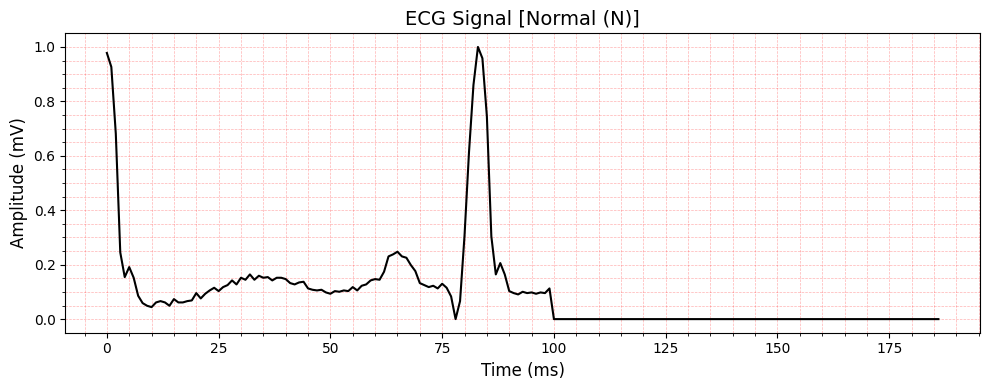

In [79]:
row = df.iloc[0, :187]
condition = df.iloc[0, 187]
condition = conditions[condition]

plt.figure(figsize=(10, 4))
plt.plot(row[0:187], color='black', linewidth=1.5)
plt.title(f"ECG Signal [{condition}]", fontsize=14)
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Amplitude (mV)", fontsize=12)
plt.grid(which='both', linestyle='--', linewidth=0.5, color='red', alpha=0.3)
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [80]:
df[df[187] == 4].iloc[0, :187]

0      0.712610
1      0.629032
2      0.527859
3      0.414956
4      0.284457
         ...   
182    0.000000
183    0.000000
184    0.000000
185    0.000000
186    0.000000
Name: 81123, Length: 187, dtype: float64

Text(0.5, 1.0, 'Classes Frequency')

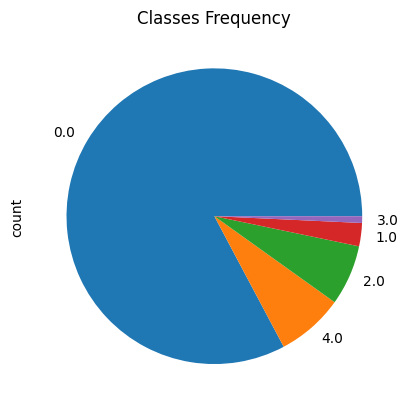

In [81]:
train_df.iloc[:, -1].value_counts().plot(kind='pie')
plt.title('Classes Frequency')

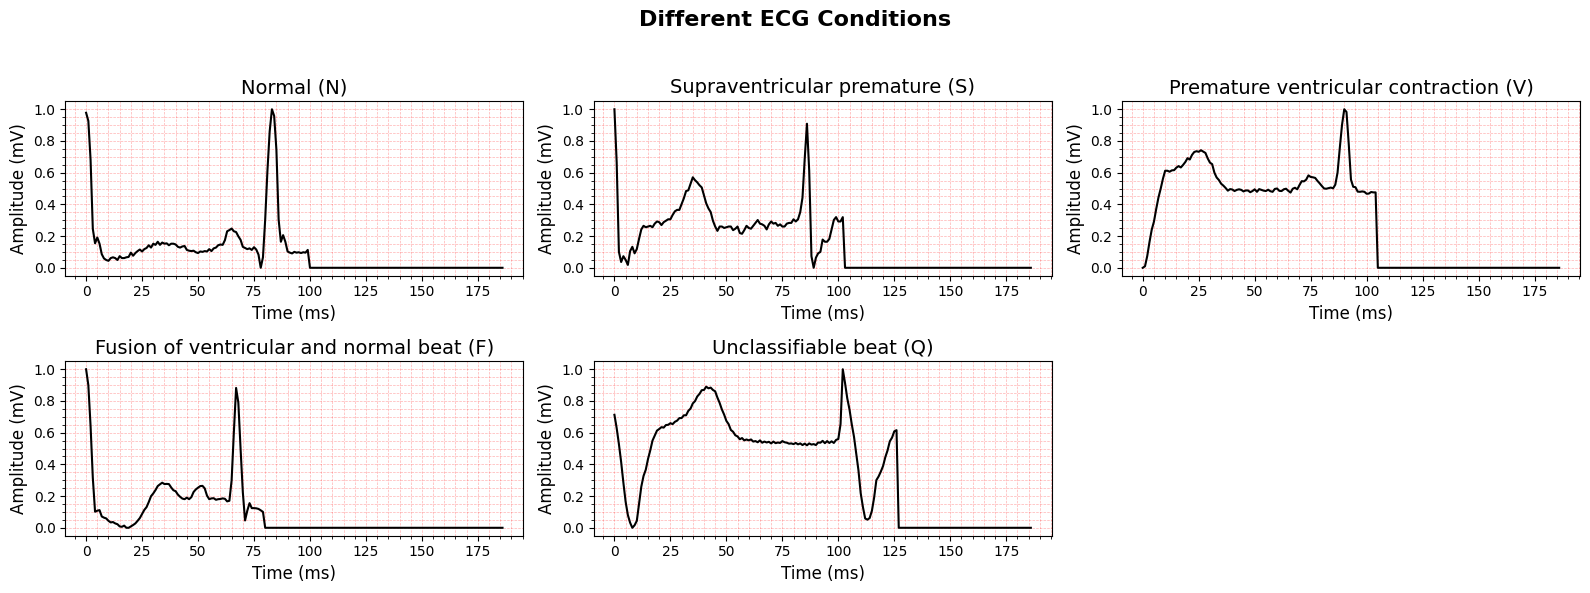

In [82]:
fig, axes = plt.subplots(2, 3, figsize=(16, 6))
for i in range(5):
    row = df[df[187] == i].iloc[0, :187]
    ax = axes[i // 3, i % 3]
    ax.plot(row[0:187], color='black', linewidth=1.5)
    ax.set_title(conditions[i], fontsize=14)
    ax.set_xlabel("Time (ms)", fontsize=12)
    ax.set_ylabel("Amplitude (mV)", fontsize=12)
    ax.grid(which='both', linestyle='--', linewidth=0.5, color='red', alpha=0.3)
    ax.minorticks_on()

fig.suptitle("Different ECG Conditions", fontsize=16, fontweight='bold')
fig.delaxes(axes[-1, -1])
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Text(0.5, 1.0, 'heartbeat signal sample')

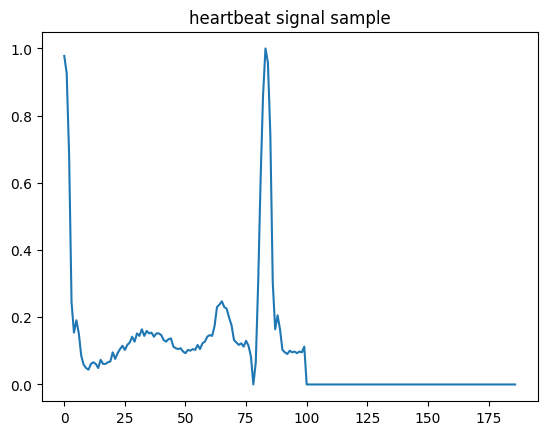

In [83]:
plt.plot(train_df.iloc[0, :-1])
plt.title('heartbeat signal sample')

In [84]:
any([df[i].isna().any() for i in range(188)])

False

In [85]:
X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
X_test, y_test = test_df.iloc[:, :-1], test_df.iloc[:, -1]

In [86]:
grouped_classes = df.groupby(187).mean()
grouped_classes

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
187,,,,,,,,,,,,,,,,,,,,,
0.0,0.915356,0.778014,0.403563,0.177536,0.164311,0.180612,0.180137,0.180581,0.183188,0.188259,...,0.003115,0.002759,0.002444,0.002190,0.001984,0.001809,0.001656,0.001446,0.001250,0.001166
1.0,0.897575,0.781740,0.272035,0.089773,0.151223,0.186248,0.175968,0.200844,0.225769,0.213789,...,0.041799,0.041910,0.042059,0.040974,0.039942,0.039711,0.039222,0.038509,0.037970,0.037959
2.0,0.604474,0.593305,0.516703,0.418160,0.373705,0.365676,0.365940,0.358152,0.339680,0.319964,...,0.027761,0.025323,0.023215,0.021724,0.019467,0.017767,0.016710,0.015829,0.014308,0.013284
3.0,0.924958,0.865178,0.609582,0.342783,0.196000,0.171894,0.156562,0.133611,0.121747,0.115655,...,0.000293,0.000233,0.000154,0.000136,0.000066,0.000066,0.000041,0.000047,0.000022,0.000041
4.0,0.860037,0.663989,0.604526,0.540759,0.478440,0.418510,0.366201,0.306952,0.244817,0.183819,...,0.000016,0.000014,0.000013,0.000013,0.000014,0.000010,0.000000,0.000000,0.000000,0.000000


In [87]:
groups = grouped_classes.index.to_list()
groups

[0.0, 1.0, 2.0, 3.0, 4.0]

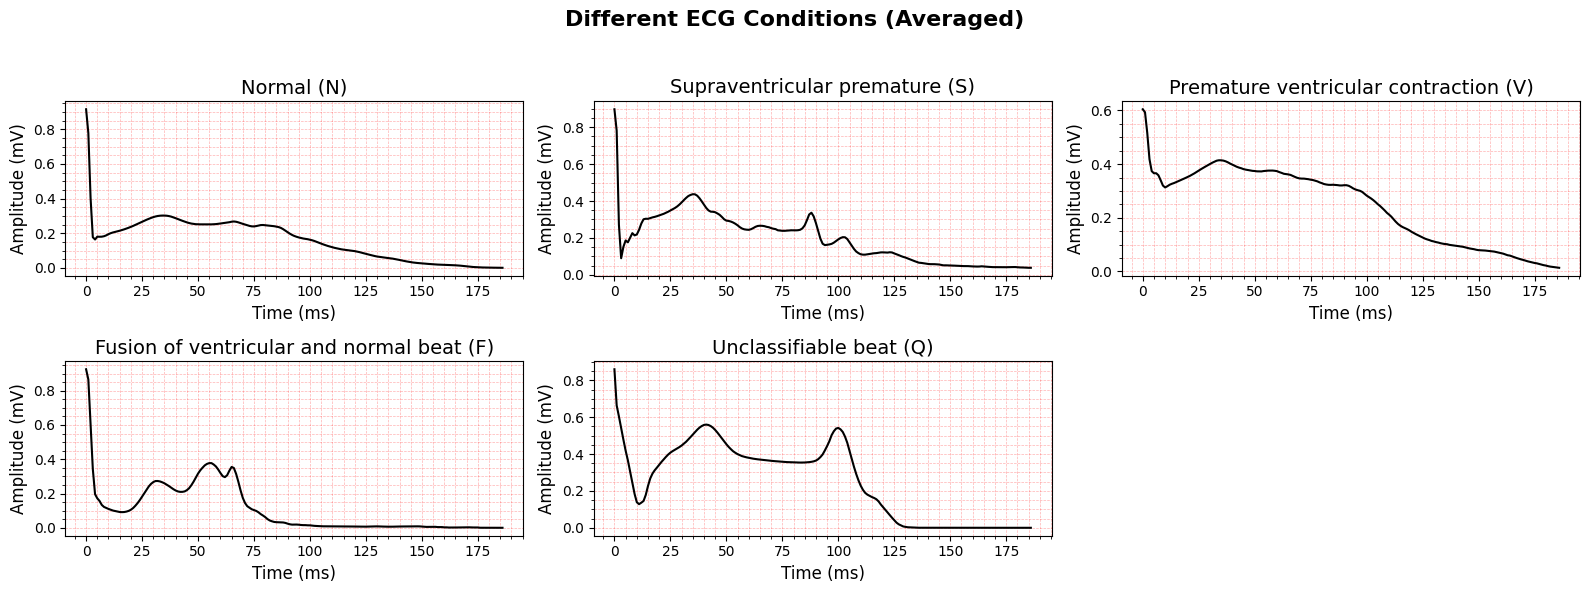

In [88]:
groups = [int(x) for x in grouped_classes.index.to_list()]

fig, axes = plt.subplots(2, 3, figsize=(16, 6))
for i in groups:
    row = grouped_classes.loc[i]
    ax = axes[i // 3, i % 3]
    ax.plot(row[0:], color='black', linewidth=1.5)
    ax.set_title(conditions[i], fontsize=14)
    ax.set_xlabel("Time (ms)", fontsize=12)
    ax.set_ylabel("Amplitude (mV)", fontsize=12)
    ax.grid(which='both', linestyle='--', linewidth=0.5, color='red', alpha=0.3)
    ax.minorticks_on()

fig.suptitle("Different ECG Conditions (Averaged)", fontsize=16, fontweight='bold')
fig.delaxes(axes[-1, -1])
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [89]:
df[187].value_counts()

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

In [90]:
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, test_size=0.5, random_state=42, stratify=y_train)

In [91]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((87554, 187), (87554,), (21892, 187), (21892,))

In [92]:
X_train_1.shape, y_train_1.shape, X_train_2.shape, y_train_2.shape

((43777, 187), (43777,), (43777, 187), (43777,))

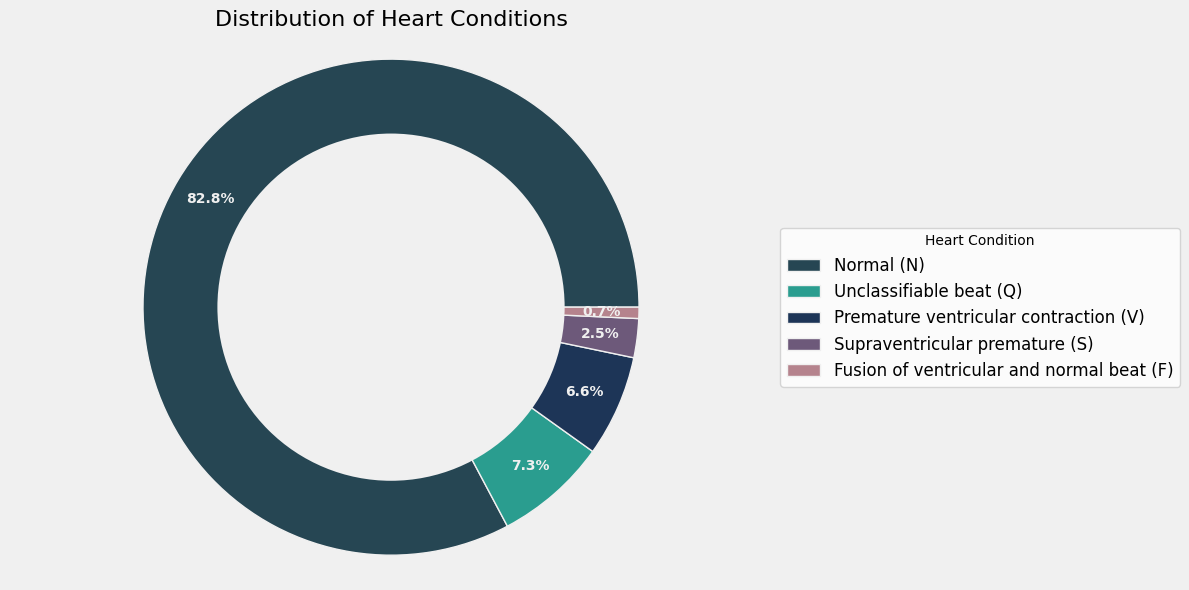

In [93]:
distribution = df[187].value_counts().to_dict()
distribution = {conditions[int(k)]: v for k, v in distribution.items()}

palette = [
    "#264653",  # dark blue-green
    "#2a9d8f",  # teal
    "#1d3557",  # deep navy
    "#6d597a",  # muted purple
    "#b5838d"   # dusty rose
]

fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f0f0f0')
wedges, texts, autotexts = ax.pie(
    list(distribution.values()), 
    labels=None, 
    colors=palette,
    pctdistance=0.85,
    autopct='%1.1f%%',
    textprops={'color': '#f0f0f0', 'fontweight': 'bold'},
    wedgeprops={'edgecolor': '#f0f0f0'}
)

centre_circle = plt.Circle((0, 0), 0.70, fc='#f0f0f0')
ax.add_artist(centre_circle)

ax.legend(
    wedges,
    list(distribution.keys()),
    title="Heart Condition",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=12
)

plt.title('Distribution of Heart Conditions', fontsize=16, color='black')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [94]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train_1, y_train_1, test_size=0.2)
X_train_1.shape, y_train_1.shape

((35021, 187), (35021,))

In [95]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Bagging": BaggingClassifier(random_state=42)
}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred, target_names=conditions.values()))

Training Logistic Regression...
Classification Report for Logistic Regression:
                                            precision    recall  f1-score   support

                               Normal (N)       0.97      0.65      0.78     14579
           Supraventricular premature (S)       0.15      0.71      0.24       426
    Premature ventricular contraction (V)       0.29      0.73      0.41      1112
Fusion of ventricular and normal beat (F)       0.09      0.89      0.17       145
                  Unclassifiable beat (Q)       0.73      0.92      0.82      1249

                                 accuracy                           0.67     17511
                                macro avg       0.45      0.78      0.48     17511
                             weighted avg       0.89      0.67      0.74     17511

Training Random Forest...
Classification Report for Random Forest:
                                            precision    recall  f1-score   support

                  

In [96]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = xgb_model.predict(X_test)
print(f"Classification Report for XGBoost:\n", classification_report(y_test, y_pred, target_names=conditions.values()))
y_pred_proba = xgb_model.predict_proba(X_test)
y_pred_proba = pd.DataFrame(y_pred_proba, columns=conditions.values())
y_pred_proba.head()

Classification Report for XGBoost:
                                            precision    recall  f1-score   support

                               Normal (N)       0.99      0.99      0.99     14579
           Supraventricular premature (S)       0.82      0.81      0.81       426
    Premature ventricular contraction (V)       0.94      0.94      0.94      1112
Fusion of ventricular and normal beat (F)       0.85      0.81      0.83       145
                  Unclassifiable beat (Q)       0.99      0.98      0.98      1249

                                 accuracy                           0.98     17511
                                macro avg       0.92      0.91      0.91     17511
                             weighted avg       0.98      0.98      0.98     17511



,Normal (N),Supraventricular premature (S),Premature ventricular contraction (V),Fusion of ventricular and normal beat (F),Unclassifiable beat (Q)
0,0.973872,0.025605,0.000089,0.000425,0.000009
1,0.996564,0.003415,0.000001,0.000015,0.000005
2,0.987114,0.003176,0.008603,0.000920,0.000187
3,0.938707,0.061082,0.000064,0.000121,0.000026
4,0.000176,0.000004,0.000012,0.000002,0.999806


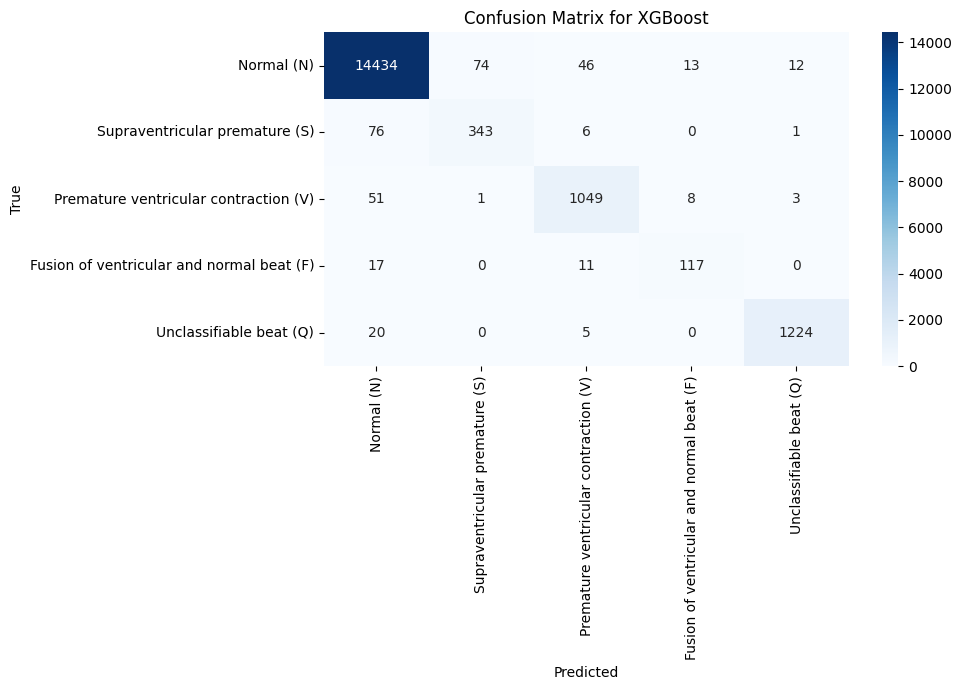

In [97]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=conditions.values(), yticklabels=conditions.values())
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [98]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping  # Import EarlyStopping

class MODEL:
    def __init__(self, input_dim, output_dim=5):
        self.model = Sequential()

        # Input layer
        self.model.add(Input(shape=(input_dim,)))  # First layer specifying input shape
        self.model.add(Dense(512, activation='relu'))
        self.model.add(BatchNormalization())

        # Hidden layers
        self.model.add(Dense(128, activation='relu'))
        self.model.add(BatchNormalization())
        
        self.model.add(Dense(128, activation='relu'))
        self.model.add(BatchNormalization())
        
        self.model.add(Dense(32, activation='relu'))
        self.model.add(BatchNormalization())
        
        # Output layer
        self.model.add(Dense(output_dim, activation='softmax'))

    def summary(self):
        self.model.summary()

    def compile_model(self):
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    def train(self, X_train, y_train, epochs=10, batch_size=32, validation_data=None):
        # Define early stopping to avoid overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        return self.model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_data,
            verbose=1,
            callbacks=[early_stopping])

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test, verbose=0)
    
    def predict(self, X):
        return self.model.predict(X)

# Ensure your training data and validation data are correctly defined
# X_train_1, y_train_1, X_val_1, y_val_1 should be the data you're using for training

model1 = MODEL(187)  # Assuming your input data has 187 features
model1.compile_model()

# Start training with your training and validation data
history = model1.train(X_train_1, y_train_1, epochs=50, batch_size=32, validation_data=(X_val_1, y_val_1))


Epoch 1/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8277 - loss: 0.6127 - val_accuracy: 0.9485 - val_loss: 0.1827
Epoch 2/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9508 - loss: 0.1766 - val_accuracy: 0.9450 - val_loss: 0.1708
Epoch 3/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9597 - loss: 0.1465 - val_accuracy: 0.9621 - val_loss: 0.1353
Epoch 4/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9583 - loss: 0.1380 - val_accuracy: 0.9605 - val_loss: 0.1326
Epoch 5/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9662 - loss: 0.1169 - val_accuracy: 0.9531 - val_loss: 0.1516
Epoch 6/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9656 - loss: 0.1123 - val_accuracy: 0.9647 - val_loss: 0.1173
Epoch 7/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9703 - loss: 0.1028 - val_accuracy: 0.9686 - val_loss: 0.1048
Epoch 8/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9723 - loss: 0.0889 -

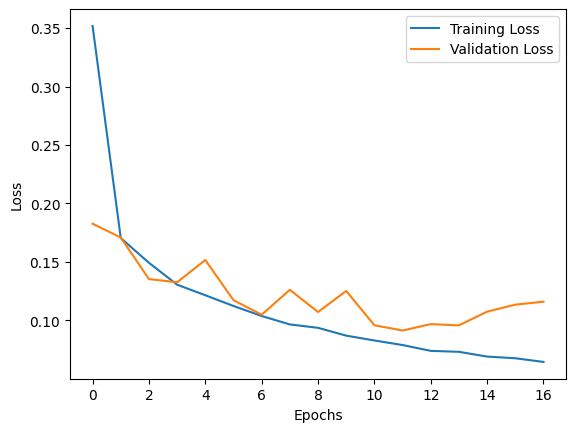

In [99]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

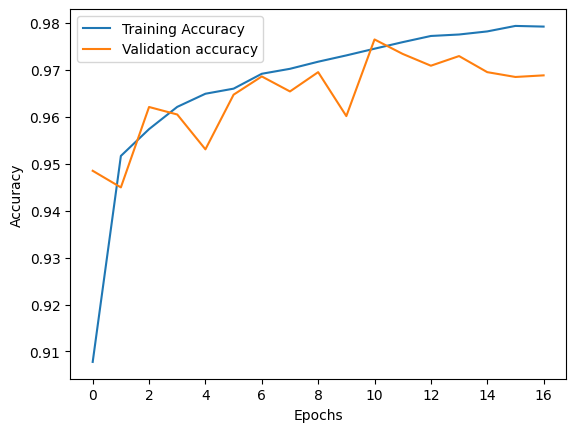

In [100]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [101]:
# Evaluate on test data
loss, accuracy = model1.evaluate(X_test, y_test)
print(f'loss: {loss}')
print(f'accuracy: {accuracy}')

loss: 0.07562924921512604
accuracy: 0.9783564805984497


In [102]:
df_test = pd.read_csv("/kaggle/input/heartbeat/mitbih_test.csv", header=None)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


                                           precision    recall  f1-score   support

                               Normal (N)       0.99      0.99      0.99     18118
           Supraventricular premature (S)       0.79      0.78      0.78       556
    Premature ventricular contraction (V)       0.95      0.95      0.95      1448
Fusion of ventricular and normal beat (F)       0.81      0.81      0.81       162
                  Unclassifiable beat (Q)       0.99      0.98      0.98      1608

                                 accuracy                           0.98     21892
                                macro avg       0.91      0.90      0.90     21892
                             weighted avg       0.98      0.98      0.98     21892



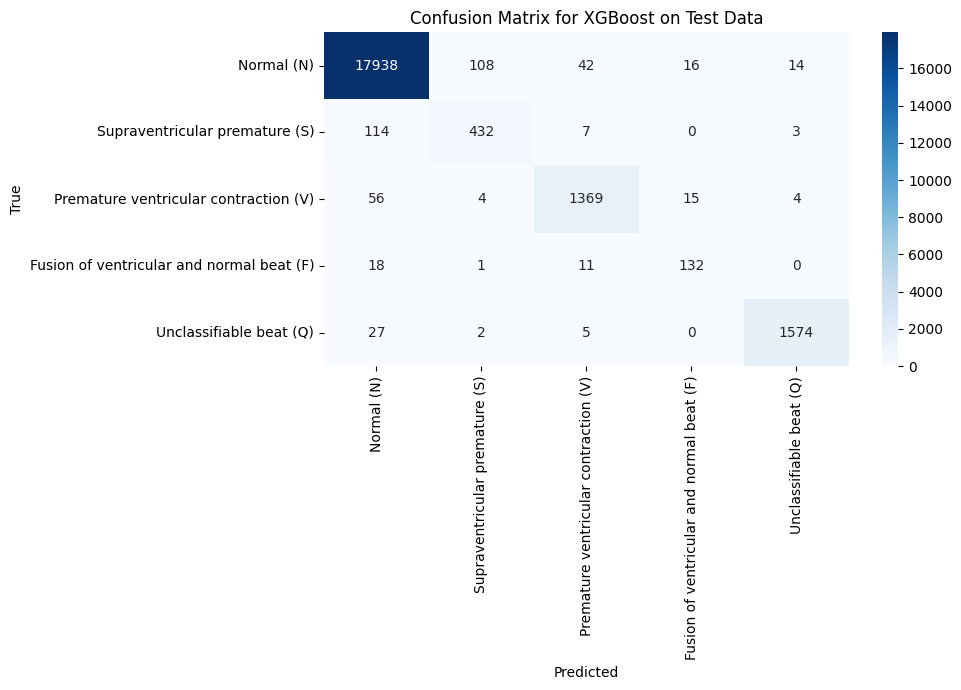

In [103]:
y_test = df_test.iloc[:, -1]
X_test = df_test.iloc[:, :-1]
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=conditions.values()))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=conditions.values(), yticklabels=conditions.values())
plt.title("Confusion Matrix for XGBoost on Test Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()